<a href="https://colab.research.google.com/github/EntropyP/CRM_Analytics/blob/main/Assignment07_Voice_of_Customer_Analytic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment07 : Voice of Customer Analytics**
The objective is to perform Voice of Customer Analytics for the review data from Wongnai dataset (Food and beverage user reviews)

Note that the summarization section will be in Thai.

# **Set up**

In [ ]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Install and import dependencies**

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 50)
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [4]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' 
#'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [5]:
df = pd.read_csv('/content/drive/My Drive/BADS7105 CRM/Wongnai Reviews - Small.csv')

In [6]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


#**Document embedding and dimension reduction**

In [7]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

#**Document clustering using KMeans**

Text(0, 0.5, 'WCSS')

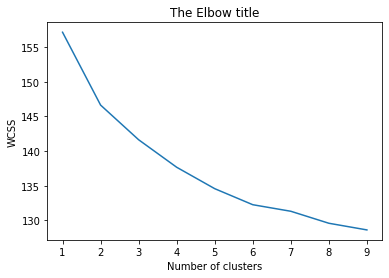

In [8]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

Choose K = 4, divided in to 4 clusters

In [9]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [10]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [11]:
df_kmeans

,KMeans ID,texts
0,0,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
1,1,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
2,2,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
3,3,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...


Remove special characters

In [12]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

Remove emojicon

In [13]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

Remove any numbers

In [14]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

Remove white space

In [15]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

Remove dot

In [16]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

Remove back slash

In [17]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

#**Word Tokenization**

In [18]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', 'กิน', 'ทาน', 'ผม','กก','สวัสดี', 'เก','ก','า','ร้า','เรา','ฉัน']
screening_words = stopwords + removed_words

new_words = {"สตารบัก", "ปลาร้า","ไม่อร่อย","เรา","หนอ","เสนอ"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='longest', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [19]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [20]:
#results of tokenization
pd.set_option('display.max_colwidth', 50)

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[วง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ปู...","[(ร้านอาหาร, 8), (อาหาร, 7), (ราคา, 4), (ซอย, ..."
1,1,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เป...,"[ไหม, ไหม, หลังอาหาร, มื้อ, อิ่, เครื่องดื่ม, ...","[(ชา, 18), (ไข่มุก, 14), (นม, 12), (เครื่องดื่..."
2,2,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, macchiato, เป็นประจำ, นึง, เด, artof...","[(ร้านกาแฟ, 22), (กาแฟ, 18), (ชอบ, 6), (คน, 5)..."
3,3,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, ออกมา, หา, อะ, ไช...","[(อร่อย, 8), (รีวิว, 7), (ครั้งแรก, 5), (ชอบ, ..."


#**Understanding each clusters**

Show top keywords of each cluster

In [21]:
top_N_words = 20

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านอาหาร', 8), ('อาหาร', 7), ('ราคา', 4), ('ซอย', 4), ('รสชาติ', 4), ('รีวิว', 3), ('ไทย', 3), ('คน', 3), ('รอบ', 3), ('เมนู', 3), ('อร่อย', 3), ('กาแฟ', 3), ('วง', 2), ('เพื่อนๆ', 2), ('อร้าน', 2), ('สไตล์', 2), ('บ้าน', 2), ('นอ', 2), ('ร่อย', 2), ('ยำ', 2)]

Cluster ID : 1

Most common words include : [('ชา', 18), ('ไข่มุก', 14), ('นม', 12), ('เครื่องดื่ม', 4), ('รีวิว', 3), ('ลอง', 3), ('ติด', 3), ('ไต้หวัน', 3), ('ไหม', 2), ('ชาเขียว', 2), ('นิว', 2), ('คุง', 2), ('เจอ', 2), ('ochaya', 2), ('มากๆ', 2), ('aprilstore', 2), ('ตั้งอยู่', 2), ('สยาม', 2), ('คน', 2), ('สไตล์', 2)]

Cluster ID : 2

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 18), ('ชอบ', 6), ('คน', 5), ('เม', 5), ('บรรยากาศ', 5), ('นึง', 4), ('กา', 4), ('นก', 4), ('วัง', 4), ('น', 4), ('คาเฟ่', 4), ('นั่ง', 4), ('เจอ', 4), ('ซอน', 4), ('ดี', 4), ('หา', 4), ('ตกแต่ง', 4), ('ตั้งอยู่', 4), (':', 3)]

Cluster ID : 3

Most common words include : [('อร่อย', 8), ('รีว

Show the original review for the interesring key words.

In [22]:
pd.set_option('display.max_colwidth', None)
df[df["Review"].str.contains("ไร้")]

,Review ID,Review,KMeans ID
71,72,จริงๆจะไปกินร้านอื่นครับที่อยู่ในซอยเดียวกัน แต่ดันแวะร้านนี้ก่อนถึงที่หมาย 555+ บรรยากาศภายนอกตอนค่ำผมนึึกว่าร้านคาราโอเกะนั่งดิ๊งค์ซะอีก ก้อเล่นติดไฟเป็นสีๆกระพริบๆ แต่พอเอาเข้าจริงต้องบอกว่าเก๋ไก๋ สไตส์ลูกทุ่งคันทรี กินกันตรงชั้น2ระเบียงร้าน ผมได้ลอง3เมนู จานแรก ส้มตำปูม้า รสชาติแซ่บดี ใช้ปูุม้าขนาดใหญ่น้องๆsizeปูนึ่งทีเดียว ปูสด เนื้อเยอะสะใสเนื้อปูหวานฉ่ำไม่คาว สุดยอดมั๊กๆ จานทีี่2 กุ้งแช่น้ำปลา จานนี้ส่วนตัวคิดว่ารสชาติธรรมดา กุ้งตัวเล็กๆไปหน่อย แต่เขาทำสะอาดดี ผ่าเอาเส้นดำหลังกุ้งออกเกลี้ยงเลย ซึ่งผิดกับร้านอื่นๆทีี่เคยกินทีี่มักจะผ่าให้แต่ไม่เอาเส้นหลังออกให้ครับ จานที่3 ปลาช่อนระเบียงไม้ วิธีทำเหมือนกะนึ่งมะนาว แต่เป็นต้มยำน้ำข้น ข้นคักจริงๆใส่นมสดหอมมันมากมาย ปลาช่อนสดตัวใหญ่sizeกำลังดี เนื้อใสไม่ยุยไร้คาว อร่อยมากกก ซึ่งเขาว่าเป็นเมนูเอกของร้าน สมราคาคุยครับ อร่อยจริงๆคอนเฟิร์ม ที่จอดรถสะดวก บริการดี เจ้าของเป็นกันเอง ราคาผมว่า ไม่แพงนะ ร้านอยู่ลึกไปหน่อยแต่ชิมรสชาติแล้วต้องบอกว่า ไม่ผิดหวังครับ,0
204,205,"สวัสดีเพื่อนๆพี่ๆชาวนักชิมแห่ง wongnai.com ทุกท่านครับ \nผม Captain Ton ขออาสาส่งความสุขให้ทุกท่านกันอีกครั้งครับ \nสามารถติดตามรีวิวต่างๆของผมได้ที่ http://www.facebook.com/CaptainTonEatTravel และ IG ค้นหา Captain_Ton ได้เลยครับ มาติดตามความอร่อยกับผมกันเยอะๆนะครับ \n\nคำว่า""บุฟเฟต์"" ราวกับความสุขของเหล่าคนชอบกินและชอบความคุ้ม วันนี้ผมจะพาทุกคนมาหาความสุขกันที่ร้าน MK Buffet สาขาฟิวเจอร์ปาร์รังสิตกันครับเพราะว่าที่นี่เป็นสาขาเดียวที่มีสุกี้บุฟเฟ่ต์ ให้ทานได้ไม่อั้นตลอดทั้งวัน และทุกวันทำการ ต่างจากสาขาอื่นที่ยกเว้นเสาร์-อาทิตย์บ้าง แต่มาที่นี่ได้ทานชัวร์ครับ \n\nส่วนราคานั้นก็มี 2 ราคาตามช่วงเวลาได้แก่ 10.00-17.00ราคา319บาท net และหลัง 17.00เป็นต้นไป 349บาท net \nจะไปทานเวลาไหนต้องจ่ายเท่าไหร่ก็ต้องวางแผนให้ดีนะครับ ส่วนเรื่องอาหารนั้นก็มีมากมายหลากหลายมาก ดูจากรูปแล้วกันนะครับ \n\nเข้ามาถึงในร้านก็เลือกที่นั่งได้ตามสะดวกเลย แต่ว่ามาเที่ยงๆแบบนี้คนเยอะมากหาที่นั่งแทบไม่ได้เลย เข้ามานั่งเกือบในสุดเลย \n\nสักพักพนักงานก็จะมาสอบถามว่ารับเป็นบุฟเฟต์ หรือ A la carte มาถึงถิ่นขนาดนี้แล้วก็ต้องจัดเต็ม!!! \nก่อนทานก็ต้องอ่านกฎระเบียบการทานด้วยนะครับ มิเช่นนั้นท่านอาจจะถูกปรับเอาได้ เดี๋ยวหาว่าไม่เตือนนะ \nสั่งเมนูที่ท่านคิดว่าอยากทาน อร่อย และคุ้ม จัดเต็มด้วย สมุดตามในฉัน(เมนู)ได้เลย \n\nไม่นานนักหม้อน้ำซุปสีแดงอันเป็นเอกลักษณ์ก็ถูกยกออกมาพร้อมน้ำซุปในหม้อ ปิดฝาเอาไว้ก่อน รอเดือดก่อนนะ \nน้ำจิ้มของMK ก็หนีไม่พ้นเจ้า2สูตร ทั้งน้ำจิ้มสุกี้สูตรดั้งเดิมและสูตรเด็กน้อย รสชาติที่คุ้นเคย \nแต่รู้สึกว่าสูตรดั้งเดิมมันจะเปรี้ยวๆไปหน่อยนะหรือเค้าปรับสูตรใหม่เพื่อลดมะนาวหว่า ??? ช่างมันเถอะ \nส่วนใครที่เคยบ่นว่าMKหวงพริก หวงกระเทียม แต่สาขาที่นี่ไม่ใช่นะครับ ให้มาเป็นถาดวางไว้บนโต๊ะเติมได้ตามใจเลย สะใจดีจัง \n\nน้ำดื่มของที่นี่ก็มีหลายอย่างนะครับ ทั้งชาจีนต้นตำรับ ชานมสูตรเข้มขันสุดๆ กาแฟ ชาเขียว และน้ำอัดลมมีให้เลือกค่อนข้างหลากหลายดีครับ แต่ที่ผมติดใจที่สุดก็ต้องเจ้านี่เลย ชานมสูตรเข้มข้นมาก ถ้าใส่ไข่มุกอีกหน่อยนี้ร้านดังๆเจ๊งแน่นอน พูดเล่นนะครับแต่มันอร่อยจริงๆนะ \n\nไม่นานนักอาหารที่สั่งไปค่อยๆทยอยมาแล้วครับ มาในทาวเวอร์สีแดงตามแบบฉบับดั้งเดิม และติ่มซำเนื้อแน่นรสชาติเยี่ยมที่ผมเดินทางมาถึงที่นี่ก็เพื่อเจ้าสิ่งนี้นี่แหละครับ จิ้มกับจิ๊กโฉ่วสูตรเฉพาะของทางร้าน อร่อยสมกับที่เดินทางมาจริงๆ \n\nขนมจีบหมูอร่อยแป้งบางเนื้อแน่นสุดๆ ขนมจีบกุ้งเนื้อแน่นเคี้ยวกี่คำก็เจอกุ้ง ฮะเก่าเนื้อแน่นแต่แป้งแต่แป้งเละไปหน่อยไม่ค่อยปลื้ม \n\nส่วนหมี่หยกของร้าน MK เหมือนจะเป็นเกรด B หรืออย่างไร เส้นใหญ่ เหนียว กระด้าง ติดกันเป็นพรืด ไม่เหมือนที่เคยทานเมื่อก่อน ผิดหวังเล็กน้อย \n\nกางออกของสดมาดูกันจะๆ ว่ามีอะไรบ้าง ดูสด น่าอร่อยไม่มีปัญหาเรื่องกลิ่นและสีสันครับ นำจับต้มให้สุกตามระเบียบ คงไม่มีใครทานดิบๆเย็นๆสินะ อิอิ \n\nจับเนื้อมาลวกๆลองชิมดูครับ นุ่มเด้งมากแต่ไม่ค่อยชอบเท่าไหร่ส่วนตัวคิดว่าเหมือนเนื้อปลอมเลย มันเด้งๆไร้กลิ่นเนื้อชืดมากเลยครับ แต่พอทานกับน้ำจิ้มของที่นี่ก็พอถูไถไปได้ \n\nทานไปทานมาชักเริ่มเบื่อ เริ่มเลี่ยน สั่งซาลาเปาหมูแดงมา1เข่ง ไส้อร่อยมากครับ แต่แป้งค่อนข้างจืด และกระด้าง สรุปคือไม่ผ่านครับ \n\nอิ่มแล้วก็ตบท้ายด้วยของหวานอย่างไอศกรีมเชอร์เบตมะนาว และทับทิมกรอบครับ ไอศกรีมเชอร์เบตของที่นี่เข้มข้นหอมกลิ่นมะนาวดีครับ \n\nและทับทิมกรอบที่น้ำเเข็งมาล้นหน้า รสชาติใสๆ หอมกลิ่นควันเทียนเล็กน้อย ผสมเนื้

In [23]:
df[df["Review"].str.contains("ไม่อร่อย")]

Review ID  ... KMeans ID
2            3  ...         0
6            7  ...         0
11          12  ...         2
16          17  ...         2
34          35  ...         3
85          86  ...         3
116        117  ...         3
135        136  ...         0
142        143  ...         3
149        150  ...         3
170        171  ...         2
235        236  ...         0
246        247  ...         3
265        266  ...         0
271        272  ...         1
275        276  ...         3
279        280  ...         3
284        285  ...         2

[18 rows x 3 columns]

In [24]:
df[df["Review"].str.contains("ร้า ")]

,Review ID,Review,KMeans ID
14,15,ตอนเย็นๆหน่อยถ้าลงจากรถไฟฟ้าราชเทวีแล้วเดินย้อนมาทางสะพานหัวช้าง ตรงฝั่งโรงแรมเอเชีย เราอาจจะเห็นร้านส้มตำเรียงรางอยู่ริมฟุตบาทสามถึงสี่ร้านด้วยกัน \n\nหลายคนอาจจะอยากลองกิน แต่ไม่รู้ร้านไหนอร่อยสุด วัดจากคนที่นั่งกินอยู่ก็ไม่ได้ เพราะว่าคนเยอะเหมือนกันเกือบทุกร้าน \n\nวันนี้เราก็เลยจะมาบอกค่ะว่าสำหรับเราร้านไหนอร่อยสุด เผื่อว่าจะเป็นทางเลือกให้เพื่อนๆที่กำลังอยากไปลอง แต่ไม่รู้จะกินร้านไหนดี ร้านนี้ไม่มีชื่อร้านนะ เพราะฉะนั้นเราบอกพิกัดเอาน่าจะง่ายสุด \n\nร้านนี้ ถ้ามาจากโรงแรมเอเชียจะถึงเป็นร้านแรกเลย อยู่ใกล้ๆกับเซเว่น ประมาณตรงหน้าคริสตจักรพอดีเลย ร้านก็จะเป็นร้านรถเข็นข้างทางทั่วไป แต่ว่าสะอาดนะ \n\nแม่ครัวแล้วก็ผู้ช่วยใส่หมวก เก็บผม สวมผ้ากับเปื้อนครบเลย แต่งตัวก็สะอาดสะอ้านดี มาดูอาหารที่เราสั่งกันบ้างดีกว่า \n\nเนื่องจากไม่ได้กินส้มตำมานาน วันนี้เราจึงสั่งกันด้วยความคลุ้มคลั่ง ทั้งหมดเก้าอย่าง มาดูตามกันไปทีละอย่างแล้วกัน\n\nมาเริ่มที่ ส้มตำไทย อันนี้อร่อย มะละกอกรอบ กุ้งแห้งตัวใหญ่ ไม่เหม็นหืน รสชาติกลมกล่อม หวานพอดี ไม่หวานมาก \n\nจานต่อไปเป็นตัวซั่วปูปลาร้า รสชาติปลาร้าเข้มข้น ปลาร้าเป็นปลาร้าต้ม สะอาดและไม่เหม็น รสชาติดี ไม่เผ็ดมาก \n\nถัดมาเป็นตับหวาน ตับชิ้นไม่เล็กไม่ใหญ่ พอดีคำ แต่ชิ้นหนา ลวกมากำลังดี ไม่แข็งเกินไป รสชาติอร่อย กลมกล่อม แต่เผ็ดไปนิดนึง \n\nจานต่อไปเป็นหมูมะนาว จานนี้เราว่าไม่ค่อยเวิร์ก หมูให้มาเยอะ แต่หมูค่อนข้างแข็ง อาจจะเป็นเพราะลวกนานไป แล้วก็รสชาติยังไม่แซ่บเท่าที่ควร คือมีแต่รสเผ็ดอย่างเดียว จานนี้ไม่ผ่าน (แต่ก็หมดนะ55)\n\n ถัดมาเป็นคอหมูย่าง จานนี้ปลื้ม หมูติดมันหน่อยๆ ไม่มันมาก ทำให้ไม่เลี่ยน หมูชิ้นหนา เคี้ยวเต็มปากเต็มคำ จิ้มน้ำจิ้มแจ่ว อร่อยมาก \n\nอีกจานเป็นเนื้อย่าง อันนี้เป็นของพี่เรา เอาแบบไม่ติดมัน เลยค่อนข้างแห้งหน่อย แต่ก็ใช้ได้นะ เนื้อไม่เหนียวมาก \n\nถัดมาเป็นปลาเผาเกลือ จำไมได้จริงๆว่าเป็นปลาสำลี หรือปลานิล แต่ว่าเนื้อปลาสดดี หวาน เค้าแร่ปลามาสวยดี เลาะก้างตรงกลางออกให้ด้วย ทานง่ายมาก น้ำจิ้มก็อร่อยดี \n\nยังไม่หมดยังมีหอยแครงลวกอีก ลวกมากำลังดีไม่สุกเกิน ไม่เลือดเกิน น้ำจิ้มก็แซ่บดี \n\nสุดท้ายเป็นจิ้มจุ่มหมู เราเอาแต่เนื้อหมู เป็นหมูสันนอก เนื้อๆเน้นๆไม่ติดมันเลย หมูนุ่ม ไม่แข็งเลย น้ำซุปก็รสชาติกลมกล่อมดี ไม่จืด \n\nหมดแล้ว เยอะมาก เก้าอย่าง สาบานว่านี่กินกันสามคน เยอะมาก กินเสร็จแทบกลิ้งกลับ\n\n ราคาทั้งหมดนี้รวมเบียร์หนึ่งขวด โค้กลิตร น้ำแข็งสองถัง แล้วก็ข้าวเหนียวสามกระติ๊บประมาณแปดร้อยนิดๆ ไม่ถึงเก้าร้อย คุ้มยิ่งกว่าคุ้มอีก ทั้งอิ่ม ทั้งอร่อย,0
35,36,"ร้านนี้ ใครๆก็รู้จักว่าเป็นร้านกาแฟ แต่อาหารของเค้าก็อร่อยนะ\nตอนนี้ ถึงแม้คาร์ฟูร์ อ่อนนุช เปลี่ยนเป็นบิ๊กซี เอ็กซ์ตร้า ไปแล้ว แต่ร้านนี้ก็ยังขายดิบขายดี ถ้าไม่รีบไปแต่วัน ก็ต้องไปคอยให้โต๊ะว่าง จะให้ดี ไปช่วง 11 โมงจะได้เลือกที่นั่งตามสบาย\n\nวันนี้ไปกันแค่ 2 คน เลือกจับจองโต๊ะริมหน้าต่าง สั่งเครื่องดื่มประจำ มอคค่าเย็น แต่หน้าเสียดายที่ ""น้ำมะขาม"" ถูกถอดออกจากเมนูแล้ว แต่สาขานี้ยังพอสั่งได้\nสั่งเมนูแนะนำ ข้าวมัน-แซลมอลย่าง-ส้มตำแอปเปิ้ล ฟิวชั่นฟูดตามสมัยนิยม กับผัดไทเกี๊ยวกรอบกุ้งสด\nถูกใจแซลมอลย่างชิ้นใหญ่ ย่างพอดีสุก สัมตำอาจจะรสอ่อนไปหน่อย ออกไปทางเปรี้ยวเนื่องจากแอปเปิ้ลเขียวรสเปรี้ยว ส่วนผัดไทนั้น เกี๊ยวทอดกรอบกำลังดี ไม่มีกลิ่นหืนน้ำมันและไม่ไหม้เกรียม\n\nตอนนี้ มีโปรโมชั่นซื้อกาแฟ&ชอคฯ 6 แก้วฟรี 1 แก้ว หมดเขต 15 ต.ค.54 เป็นการฉลองรางวัลชนะเลิศบาริสต้าและลาเต้อาร์ต 12 รางวัล\n",0
95,96,"กราบขออภัยสำหรับ...คำพูด แต่ผมมีความรู้สึกอย่างนั้นจริงๆ\n\n""แฟชั่นไอซ์แลนด์"" เป็นสถานที่ที่ผมไปบ่อยมาก สำหรับการฝากท้อง การซื้อของ หรือจิบปาถะมากมาย\nร้านอาหารก็ผ่านมาแล้วมากมาย เรียกได้ว่า ตั้งแต่ร้านน้อยใหญ่ ฟู๊ดคอร์ท ร้านไอติม ร้านกาแฟ แต่วันนี้ผมได้มามาลอง\nกิน ร้าน ""โพนยางคำ"" แบบ A La Carte บนสายพาน ก่อนจะย่างเข้าไป ก็ตามธรรมชาติของผม อ่านโปสเตอร์หน้า\nร้านบ้าง อ่านคำแนะนำตัวใหญ่ๆบ้าง แต่คงอ่านไม่ละเอียดเท่าไหร่ เห็นแว่บ แว๊บแหละ \n\n""เนื้อประมาณเทพ บร่า บรา บรา ทาน 4 จานจ่าน 3 จาน"" และอีกหลายแผ่นโฆษณา แบบลวกๆ\n\nเดินเข้าไปเห็นอาหารเรียงรายบนสายพาน ได้โต๊ะด้านหลังๆ ระยะการเดินไปที่โต๊ะสังเกตุอาหารบนสายพานประเมินด้วยสายตา\n\nจานของคาว ไม่น่าเกิน 8-9 อย่าง ผัก 3-4 อย่าง ของหวานก็มีบนสายพานอีกนิดหน่อย ก็รู้สึกนิดๆนะว่าเออมันจะมีอะไรกินบ้างหนอ เอาวะไหนไหน ก็เข้ามาแล้ว ลองดูสักตั้งก็ไม่เป็นไร\n\nวันนี้ผมมาผู้ใหญ่ กินเยอะ 2 ท่าน ไม่ค่อยกินหุ่นนางงาม 2 ท่าน เด็กเล็กประมาณจิ้มไส้กรอก 2 ชิ้นอ

In [25]:
df[df["Review"].str.contains("นอ ")]

Review ID  ... KMeans ID
95          96  ...         3
249        250  ...         0

[2 rows x 3 columns]

In [26]:
df[df["Review"].str.contains("วัง")]

Review ID  ... KMeans ID
4            5  ...         3
6            7  ...         0
25          26  ...         3
27          28  ...         3
32          33  ...         2
37          38  ...         2
48          49  ...         2
63          64  ...         2
69          70  ...         0
70          71  ...         3
71          72  ...         0
76          77  ...         3
83          84  ...         2
89          90  ...         3
96          97  ...         0
100        101  ...         2
118        119  ...         2
123        124  ...         0
138        139  ...         0
141        142  ...         0
147        148  ...         2
149        150  ...         3
165        166  ...         2
172        173  ...         3
174        175  ...         3
192        193  ...         1
195        196  ...         3
201        202  ...         3
204        205  ...         3
205        206  ...         2
212        213  ...         2
213        214  ...         2
227        228  ...         0
245        246  ...         3
249        250  ...         0
252        253  ...         3
254        255  ...         0
256        257  ...         2
263        264  ...         3
269        270  ...         3
279        280  ...         3

[41 rows x 3 columns]

In [27]:
df[df["Review"].str.contains("[ก-ฮ]สา")]

,Review ID,Review,KMeans ID
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน อยู่ในซอยราชครูเข้ามานิดเดียวทางซ้ายมือ\nที่จอดรถค่อนข้างน้อยเพราะต้องแชร์กับร้านค้าในเวิ้งเดียวกัน บางครั้งอาจต้องออกไปจอดตามซอยข้างๆ\n\nอาหารที่นี่มีหลายหลากเมนู อร่อยทุกเมนูที่เคยทาน น้ำจิ้มให้มาอย่างสะใจ ขอเพิ่มได้ตลอด \nร้านตกแต่งเหมือนร้านอาหารเวียดนามทั่วไป คือต้องมีรูปเกี่ยวกับเวียดนามและหญิงสาวเวียดนามแต่งตัวมาอวดทรวดทรงที่ผอมบางเพราะทานกันแต่ผัก \nผิดหวังอย่างเดียวคือกาแฟเวียดนามไม่ได้มาในถ้วยกดให้น้ำหยด แต่ชงมาให้สำเร็จ รสชาติเลยไม่เข้มข้นและออกหวานเกินไป สั้งพวกน้ำผลไม้ปั่นแทน\nราคาเหมาะสมกับคุณภาพและปริมาณ\n,3
13,14,เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่อให้อิ่มยังง๊ายยังไงก็ต้องจัดของหวานต่อ ไม่ว่าจะเป็นเค้ก ไอศครีม น้ำหวาน บลาๆๆ ...\n\nจริงๆ ตอนเด็กๆ ก็ไม่เคยเรียนนะคะ ว่ากระเพาะคนเราแยกส่วนของคาว ของหวานได้ เช่นตอนนี้กระเพาะส่วนของคาวเต็มแม๊กซ์แล้ว แต่ยังพื้นที่ยังเหลือสำหรับส่วนของหวาน ดังนั้นเธอสามารถไปต่อได้จ้ะ ยังไงก็ตาม คนส่วนใหญ่ (รวมถึงอิฉัน) ไปต่อค่ะ\n\nวันนี้เป็นชานมไข่มุก สัญชาติไต้หวันค่ะ ราคาเริ่มที่ 40 บาทใต้ตึกเอ็มไพร์ค่ะ ไม่ต้องตามมาถึงนี่นะคะ ร้านเค้ามี10กว่าสาขา ในหลายห้าง รวมถึงสถานที่ที่วัยรุ่น (อย่างพวกเรา) ชอบไปอยู่แล้ว เช่น สยามค่ะ\n\nเมนูก็หลากหลายดี มีทั้งชา กาแฟ สมูตตี้ และยังมีพวกแนวผลไม้ เช่น สตอเบอรี่ค่ะ\n\nท้อปปิ้งก็เปลี่ยนได้นะ นอกจากไข่มุก ก็มีเยลลี่ พุดดิ้ง เฉาก๊วย โอเรโอ (บางครั้งเลือกไม่ถูก จบที่ใส่ทุกอย่าง)\n\nรูปวันนี้เป็นชานม สำหรับเด็กกำลังโต (ด้านข้าง) ต้องการพลังงานสูง ในวันที่ต้องรีบส่งงานให้เจ้านายค่ะ\n\nรสชาติ โอเค มาได้เรื่อยๆ เวลาต้องการใช้พลัง จริงๆรสชาติไม่ได้ต่างจากชานมเจ้าอื่นอะไรมากนักค่ะ \n\nตอนนี้มีโปรโมชั่น อัพไซท์ ของคนใช้เครือข่ายทรู จ่ายราคาไซท์ เอ็ม 40 บาท แต่ได้ดื่มไซท์ ใหญ่ราคา 50 บาทค่ะ หมดเขต 30 กย 57 ค่ะ\n,1
14,15,ตอนเย็นๆหน่อยถ้าลงจากรถไฟฟ้าราชเทวีแล้วเดินย้อนมาทางสะพานหัวช้าง ตรงฝั่งโรงแรมเอเชีย เราอาจจะเห็นร้านส้มตำเรียงรางอยู่ริมฟุตบาทสามถึงสี่ร้านด้วยกัน \n\nหลายคนอาจจะอยากลองกิน แต่ไม่รู้ร้านไหนอร่อยสุด วัดจากคนที่นั่งกินอยู่ก็ไม่ได้ เพราะว่าคนเยอะเหมือนกันเกือบทุกร้าน \n\nวันนี้เราก็เลยจะมาบอกค่ะว่าสำหรับเราร้านไหนอร่อยสุด เผื่อว่าจะเป็นทางเลือกให้เพื่อนๆที่กำลังอยากไปลอง แต่ไม่รู้จะกินร้านไหนดี ร้านนี้ไม่มีชื่อร้านนะ เพราะฉะนั้นเราบอกพิกัดเอาน่าจะง่ายสุด \n\nร้านนี้ ถ้ามาจากโรงแรมเอเชียจะถึงเป็นร้านแรกเลย อยู่ใกล้ๆกับเซเว่น ประมาณตรงหน้าคริสตจักรพอดีเลย ร้านก็จะเป็นร้านรถเข็นข้างทางทั่วไป แต่ว่าสะอาดนะ \n\nแม่ครัวแล้วก็ผู้ช่วยใส่หมวก เก็บผม สวมผ้ากับเปื้อนครบเลย แต่งตัวก็สะอาดสะอ้านดี มาดูอาหารที่เราสั่งกันบ้างดีกว่า \n\nเนื่องจากไม่ได้กินส้มตำมานาน วันนี้เราจึงสั่งกันด้วยความคลุ้มคลั่ง ทั้งหมดเก้าอย่าง มาดูตามกันไปทีละอย่างแล้วกัน\n\nมาเริ่มที่ ส้มตำไทย อันนี้อร่อย มะละกอกรอบ กุ้งแห้งตัวใหญ่ ไม่เหม็นหืน รสชาติกลมกล่อม หวานพอดี ไม่หวานมาก \n\nจานต่อไปเป็นตัวซั่วปูปลาร้า รสชาติปลาร้าเข้มข้น ปลาร้าเป็นปลาร้าต้ม สะอาดและไม่เหม็น รสชาติดี ไม่เผ็ดมาก \n\nถัดมาเป็นตับหวาน ตับชิ้นไม่เล็กไม่ใหญ่ พอดีคำ แต่ชิ้นหนา ลวกมากำลังดี ไม่แข็งเกินไป รสชาติอร่อย กลมกล่อม แต่เผ็ดไปนิดนึง \n\nจานต่อไปเป็นหมูมะนาว จานนี้เราว่าไม่ค่อยเวิร์ก หมูให้มาเยอะ แต่หมูค่อนข้างแข็ง อาจจะเป็นเพราะลวกนานไป แล้วก็รสชาติยังไม่แซ่บเท่าที่ควร คือมีแต่รสเผ็ดอย่างเดียว จานนี้ไม่ผ่าน (แต่ก็หมดนะ55)\n\n ถัดมาเป็นคอหมูย่าง จานนี้ปลื้ม หมูติดมันหน่อยๆ ไม่มันมาก ทำให้ไม่เลี่ยน หมูชิ้นหนา เคี้ยวเต็มปากเต็มคำ จิ้มน้ำจิ้มแจ่ว อร่อยมาก \n\nอีกจานเป็นเนื้อย่าง อันนี้เป็นของพี่เรา เอาแบบไม่ติดมัน เลยค่อนข้างแห้งหน่อย แต่ก็ใช้ได้นะ เนื้อไม่เหนียวมาก \n\nถัดมาเป็นปลาเผาเกลือ จำไมได้จริงๆว่าเป็นปลาสำลี หรือปลานิล แต่ว่าเนื้อปลาสดดี หวาน เค้าแร่ปลามาสวยดี เลาะก้างตรงกลางออกให้ด้วย ทานง่ายมาก น้ำจิ้มก็อร่อยดี \n\nยังไม่หมดยังมีหอยแครงลวกอีก ลวกมากำลังดีไม่สุกเกิน ไม่เลือดเกิน น้ำจิ้มก็แซ่บดี \n\nสุดท้ายเป็นจิ้มจุ่มหมู เราเอาแต่เนื้อหมู เป็นหมูสันนอก เนื้อๆเน้นๆไม่ติดมันเลย หมูนุ่ม ไม่แข็งเลย น้ำซุปก็รสชาติกลมกล่อมดี ไม่จืด \n\nหมดแล้ว เยอะมาก เก้าอย่าง สาบานว่านี่กินกันสามคน เยอะมาก กินเสร็จแทบกลิ้งกลับ\n\n ราคาทั้งหมดนี้รวมเบียร์หนึ่งขวด โค้กลิตร น้ำแข็งสองถัง แล้วก็ข้าวเหนียวสามกระติ๊บประมาณแปดร้อยนิดๆ ไม่ถึงเก้าร้อย คุ้มยิ่งกว่าคุ้มอีก ทั้งอิ่ม ทั้งอร่อย,0
18,19,เคยทานทองม้วนสดมาหลายร้านแล้ว \nถ้าจะทานแบบอร่อยๆ ใส่มะพ

#**Result discussion**

Tuning List

*   Remove UMAP (Use 512-dimensions embedded vectors)
*   Remain Kmean K = 4
*   Change tokenization method to "Longest"
*   Add remove word ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', 'กิน', 'ทาน', 'ผม','กก','สวัสดี', 'เก','ก','า','ร้า','เรา','ฉัน']
*   Add new word {"สตารบัก", "ปลาร้า","ไม่อร่อย","เรา","หนอ","เสนอ"}
*   Query some interesting word to read full review

Group 1 : Restaurant Reviewer
> กลุ่มนี้เน้นรีวิวร้านอาหารเป็นหลัก หลากหลายราคาและประเภทของอาหาร ภาพรวมจะรีวิวออกมาในแง่บวก ทั้งในด้านของ รสชาติอาหาร ราคาและบริการ

Group 2 : Cafe Hopper
> กลุ่มนี้เน้นรีวิวร้านกาแฟและคาเฟ่น่ารักๆหรือมีสไตล์ ชอบ ชานมไข่มุก เค้ก เบเกอรี่เป็นพิเศษ นักรีวิวเป็นเพศหญิงมากกว่าเพศชาย

Group 3 : Coffe Lover
> กลุ่มนี้เน้นรีวิวกาแฟ เป็นนักดื่มที่พร้อมละเมียดละไมกับรสชาติกาแฟ ขอเพียงกาแฟถูกปาก คุณภาพดี ไม่ว่าจะอยู่แห่งหนใดก็จะสรรหามารีวิว ตัวอย่างยอดฮิตเช่นกาแฟนรสิงห์ วังพญาไท จนไปถึง กาแฟเจลลี่บีนในตรอกซอกซอยก็มีมาให้รีวิวกัน 

Group 4 : Criticizer
> กลุ่มนี้เน้นการรีวิวสะท้อนคุณภาพของร้านอาหารเทียบกับราคาที่จ่ายไปว่าสมเหตุสมผลหรือไม่ เป็น real voice from customers หลายๆรีวิวอาจได้รับการบริการที่ไม่ดี รสชาติอาหารที่ไม่สมกับความคาดหวังจึงมีการบ่น ตำหนิ หรือกระทั่งด่า ถือว่าเป็นกลุ่มที่ชมแรงด่าแรง

